In [114]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **LOAD DATASET**

In [115]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras.callbacks import EarlyStopping

In [116]:
BATCH_SIZE = 64
IMAGE_SIZE = 255
CHANNEL = 3
EPOCHS = 20

In [117]:
# load images và labels
ds = tf.keras.preprocessing.image_dataset_from_directory(
  directory='/content/drive/MyDrive/Colab Notebooks/crop-disease-classification/dataset/Potato',
  seed=123,       # kết quả giống nhau mỗi lần xáo trộn
  shuffle = True,
  image_size=(IMAGE_SIZE,IMAGE_SIZE),  # 255x255
  batch_size = BATCH_SIZE,
)

ds

Found 1510 files belonging to 3 classes.


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 255, 255, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [118]:
total_batch = len(ds)  #tổng số batch: 1510/32
total_batch

24

1 epoch = tổng số batch = n/batch_size

In [119]:
# 3 nhãn theo thứ tự index
class_names = ds.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [120]:
len(ds.take(1))

for images_tf, labels_tf in ds.take(1):  # dữ liệu trên batch đầu tiên
    print("@@@@@@@@ Image Batch Shape:", images_tf.shape)
    print("@@@@@@@@ Single image:", images_tf[0])
    print("@@@@@@@@@ Label numpy:", labels_tf.numpy)

@@@@@@@@ Image Batch Shape: (64, 255, 255, 3)
@@@@@@@@ Single image: tf.Tensor(
[[[143.90207  141.90207  155.90207 ]
  [119.0101   117.0101   131.0101  ]
  [119.314804 117.314804 131.3148  ]
  ...
  [188.98439  190.98439  202.98439 ]
  [186.97835  188.97835  200.97835 ]
  [188.97646  190.97646  202.97646 ]]

 [[118.898094 116.898094 130.8981  ]
  [124.070145 122.070145 136.07013 ]
  [149.64659  147.64659  161.64659 ]
  ...
  [166.1545   168.1545   180.1545  ]
  [170.05882  172.05882  184.05882 ]
  [179.05304  181.05304  193.05304 ]]

 [[100.1866    98.1866   112.1866  ]
  [110.40687  108.40687  122.40687 ]
  [122.895134 120.895134 134.89514 ]
  ...
  [179.02863  181.02863  193.02863 ]
  [183.90247  185.90247  197.90247 ]
  [190.81007  192.81007  204.81007 ]]

 ...

 [[105.11829  106.11829  126.11829 ]
  [125.57121  126.57121  146.5712  ]
  [146.90833  147.90833  167.90833 ]
  ...
  [119.00845  124.00845  146.00845 ]
  [128.7561   133.7561   155.7561  ]
  [ 98.34372  103.34372  125.3437

# **TRỰC QUAN HÓA DỮ LIỆU**

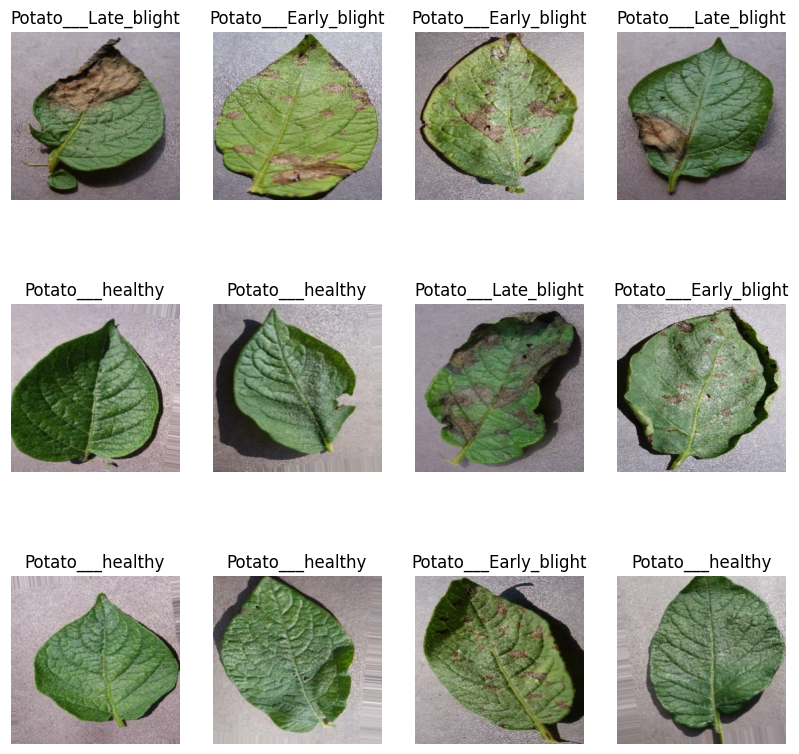

In [121]:
def display_imgs():
  plt.figure(figsize=(10, 10)) #10 inch × 10 inch

  for images_tf, labels_tf in ds.take(1):
      for item in range(12):
          ax = plt.subplot(3, 4, item + 1) # vẽ trục: 3x4, bắt đầu từ ô thứ 1
          plt.imshow(images_tf[item].numpy().astype("uint8"))
          plt.title(class_names[labels_tf[item]])
          plt.axis("off")

display_imgs()

# **CHIA DỮ LIỆU**

In [122]:
train_ds = ds.take(round(total_batch*0.8)) #80%
len(train_ds)

19

In [123]:
remain_batch=ds.skip(len(train_ds))  #20%
len(remain_batch)

5

In [124]:
val_ds = remain_batch.take(round(total_batch * 0.1))
len(val_ds)

2

In [125]:
test_ds = remain_batch.skip(len(val_ds))
len(test_ds)

3

In [126]:
def split_dataset (ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    total_batch = len(ds)

    if shuffle:
      ds = ds.shuffle(shuffle_size, seed=12)

    train_ds = ds.take(round(total_batch*0.8)) #80%
    remain_batch=ds.skip(len(train_ds))  #20%
    val_ds = remain_batch.take(round(total_batch * 0.1))
    test_ds = remain_batch.skip(len(val_ds))

    return train_ds, val_ds, test_ds

train_ds, val_ds, test_ds = split_dataset(ds)

# **TỐI ƯU HÓA QUÁ TRÌNH TIỀN XỬ LÝ DỮ KIỆU**

In [127]:
#. resize + scale
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.Rescaling(1./255),  # chuẩn hóa giá trị pixel ([0, 255]) về [0, 1]
])

# train_ds = train_ds.map(lambda x, y: (resize_and_rescale(x), y))
# val_ds = val_ds.map(lambda x, y: (resize_and_rescale(x), y))
# test_ds = test_ds.map(lambda x, y: (resize_and_rescale(x), y))

In [128]:
def optimize_data_preprocessing(train_ds, val_ds, test_ds):
  data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"), #lật
    layers.RandomRotation(0.2), #xoay
  ])

  #. tăng cường dữ liệu cho tập train
  train_ds = train_ds.map(
      lambda x, y: (data_augmentation(x, training=True), y)  # chỉ khi train
  ).prefetch(buffer_size=tf.data.AUTOTUNE)

  #. cache, shuffle và prefetch
  train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
  val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
  test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

  return train_ds, val_ds, test_ds

train_ds, val_ds, test_ds = optimize_data_preprocessing(train_ds, val_ds, test_ds)

# **MODEL**

In [129]:
# kiến trúc model

input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNEL)  # input phải tính theo batch_size
model = models.Sequential([
    resize_and_rescale,

    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape), # 32 kernel
    # layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    # layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    # layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    # layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    # layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),

    # fully-connected, 128 notron
    layers.Dense(128, activation='relu'),

    # softmax phân loại nhiều lớp
    layers.Dense(len(class_names), activation='softmax'), # 3 notron cho output-layer
])

model.build(input_shape=input_shape)
model.summary()

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_12 (Sequential)           │ (64, 255, 255, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (64, 253, 253, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_19 (MaxPooling2D)      │ (64, 126, 126, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_20 (Conv2D)                   │ (64, 124, 124, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_20 (MaxPooling2D)      │ (64, 62, 62, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_21 (Conv2D)                   │ (64, 60, 60, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_21 (MaxPooling2D)      │ (64, 30, 30, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_22 (Conv2D)                   │ (64, 28, 28, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_22 (MaxPooling2D)      │ (64, 14, 14, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_23 (Conv2D)                   │ (64, 12, 12, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_23 (MaxPooling2D)      │ (64, 6, 6, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (64, 4608)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (64, 128)                   │         589,952 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (64, 3)                     │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 868,099 (3.31 MB)

 Trainable params: 868,099 (3.31 MB)

 Non-trainable params: 0 (0.00 B)

In [130]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), # CategoricalCrossentropy cho one-hot label, from_logits=False vì đã sd softmax
    metrics=['accuracy']  # tỷ lệ dự đoán đúng so với tổng số dự đoán
)

In [131]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=16,
    restore_best_weights=True
)

# fit và train
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
    callbacks=[early_stopping]
)

Epoch 1/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 38s 592ms/step - accuracy: 0.3687 - loss: 1.0895 - val_accuracy: 0.6863 - val_loss: 0.8897
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - accuracy: 0.6398 - loss: 0.7756 - val_accuracy: 0.8529 - val_loss: 0.4268
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - accuracy: 0.8748 - loss: 0.3684 - val_accuracy: 0.8235 - val_loss: 0.3987
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 105ms/step - accuracy: 0.8828 - loss: 0.2909 - val_accuracy: 0.9020 - val_loss: 0.2297
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step - accuracy: 0.9191 - loss: 0.2086 - val_accuracy: 0.8431 - val_loss: 0.3350
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 104ms/step - accuracy: 0.9271 - loss: 0.1921 - val_accuracy: 0.9216 - val_loss: 0.2490
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 104ms/step - accuracy: 0.9353 - loss: 0.1818 - val_accuracy: 0.9314 - val_loss: 0.2121
Epoch 8/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - accuracy: 0.9281 - loss: 0.1739 - val_accuracy: 0

# **ĐÁNH GIÁ MODEL**

In [132]:
scores = model.evaluate(test_ds)

3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - accuracy: 0.9889 - loss: 0.0180


In [133]:
print(history)
print(history.params)
print(history.history.keys())

{'verbose': 1, 'epochs': 50, 'steps': 19}
dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


In [134]:
history.history['loss'][:5]

[1.0715324878692627,
 0.6716987490653992,
 0.35480910539627075,
 0.26059845089912415,
 0.21406713128089905]

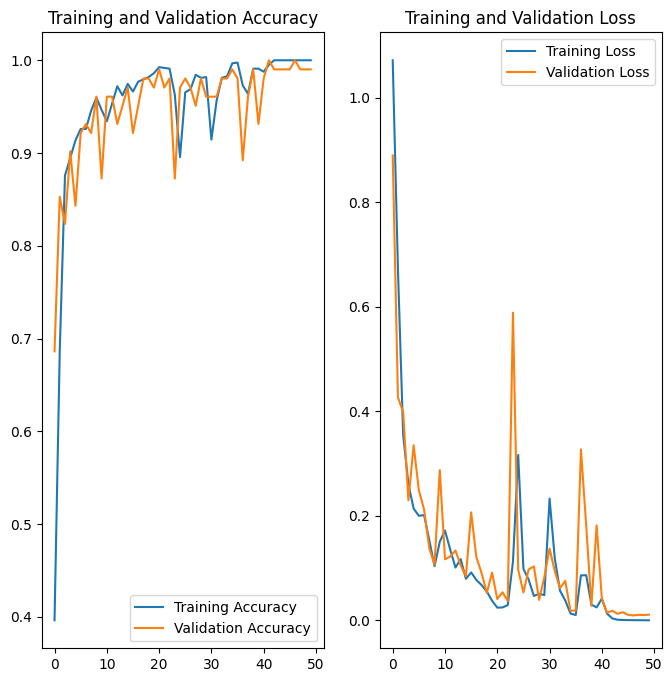

In [135]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']


plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(len(acc)), acc, label='Training Accuracy') # Changed to len(acc) or len(val_acc)
plt.plot(range(len(val_acc)), val_acc, label='Validation Accuracy') # Changed to len(acc) or len(val_acc)
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(len(loss)), loss, label='Training Loss') # Changed to len(loss) or len(val_loss)
plt.plot(range(len(val_loss)), val_loss, label='Validation Loss') # Changed to len(loss) or len(val_loss)
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [136]:
model.save("/content/drive/MyDrive/crop-disease-classification/model/model.h5")

# **DỰ ĐOÁN**

In [137]:
model = tf.keras.models.load_model('/content/drive/MyDrive/crop-disease-classification/model/model.h5')

Shape: (64, 255, 255, 3)
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step 
actual label: Potato___healthy
predicted label: Potato___healthy


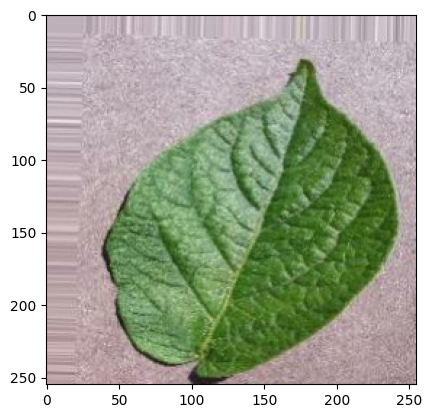

In [138]:
# test
for images_tf, labels_tf in test_ds.take(1):
    print("Shape:", images_tf.shape)

    imgs_predict = resize_and_rescale(images_tf)
    y_predict = model.predict(images_tf)  #2D

    print("actual label:", class_names[labels_tf[9]])
    print("predicted label:",class_names[np.argmax(y_predict[9])])

    plt.imshow(images_tf[9].numpy().astype("uint8"))

In [ ]:
import numpy as np

def predict(img_tf):
    # chuyển ảnh đơn lẽ (h, w, rgb) sang (batch_size, h, w, rgb) (tính theo batch_size (nhiều ảnh))
    array_input = tf.keras.preprocessing.image.img_to_array(img_tf) # 1D
    array_input = tf.expand_dims(array_input, 0)   # thêm chiều

    # img_tf = resize_and_rescale(array_input)   # đầu vào phải là (batch_size, h, w, rgb)

    y_predicted = model.predict(array_input) # return 2D

    predicted_label = class_names[np.argmax(y_predicted[0])]  # lấy chỉ mục của giá trị lớn nhất

    predicted_score = round(100 * (np.max(y_predicted[0])), 2) # chuyển về %

    return [predicted_label, predicted_score]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━

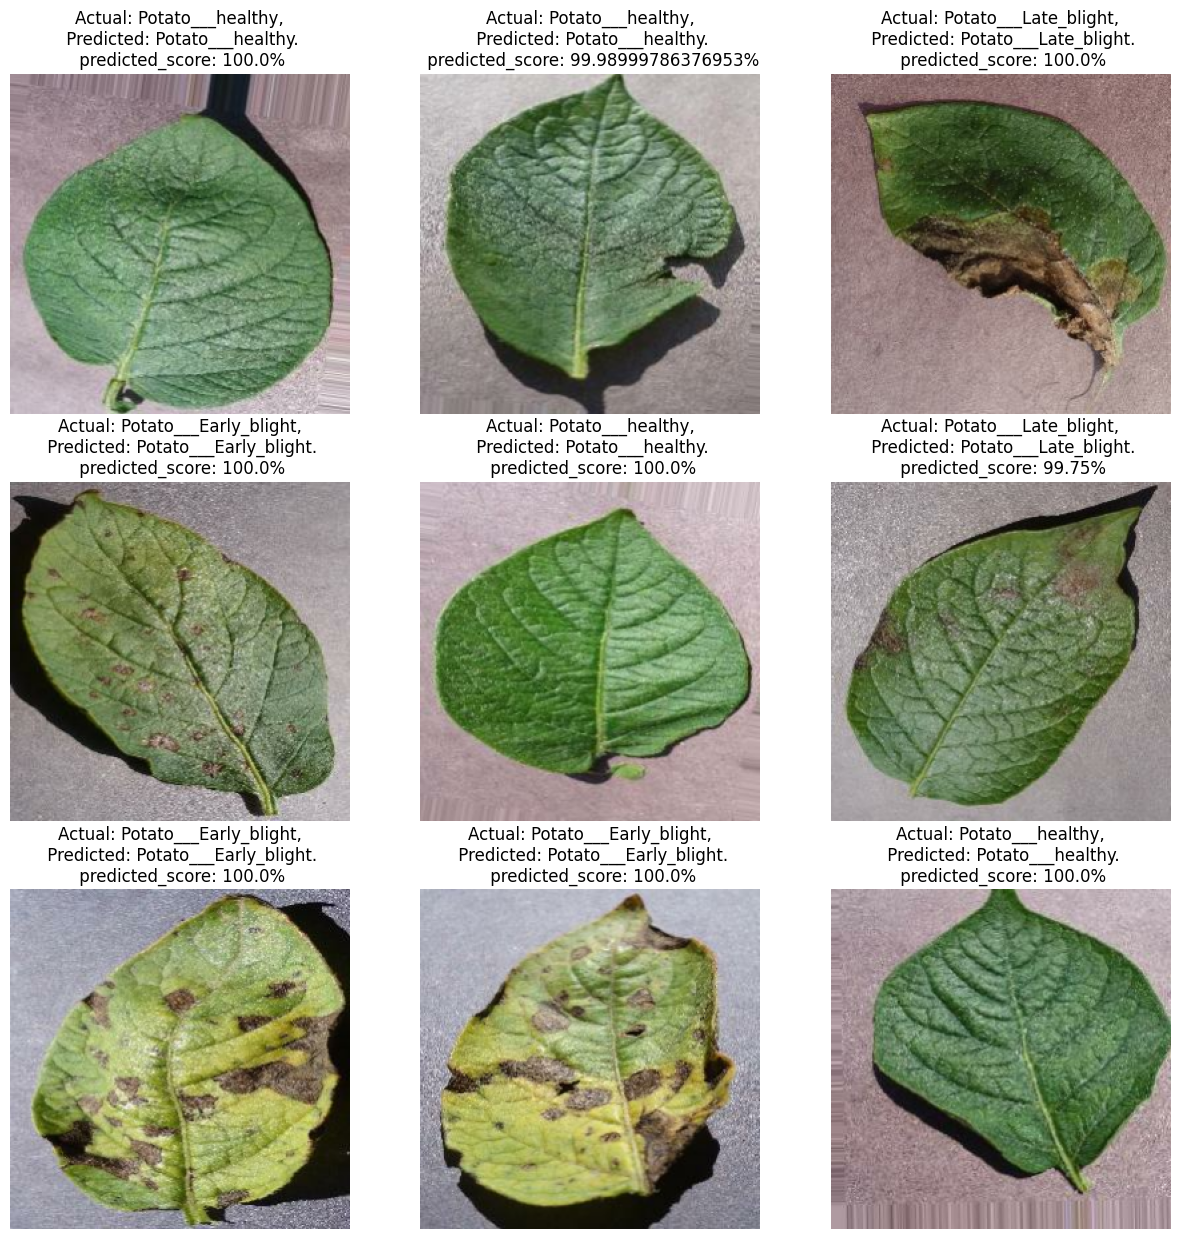

In [140]:
plt.figure(figsize=(15, 15))

for images_tf, labels_tf in test_ds.take(6):
    for i in range(9):
        predicted_label, predicted_score = predict(images_tf[i])

        actual_label = class_names[labels_tf[i]]

        ax = plt.subplot(3, 3, i + 1)
        plt.title(f"Actual: {actual_label},\n Predicted: {predicted_label}.\n predicted_score: {predicted_score}%")
        plt.axis("off")
        plt.imshow(images_tf[i].numpy().astype("uint8"))